In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
# Prediction libraries
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import plot_tree, export_text
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
#
import lasio
import segyio
import dask.array as da
import dask.dataframe as ddf
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Dict, List, Tuple, Callable

In [3]:
filepath = '‪E:\\Datasets\\reservior_simulation\\dataset\\f3_volume_of_shale.csv'  # Your original path

# Clean the path by encoding to ASCII and decoding, ignoring errors.
cleaned_filepath = filepath.encode('ascii', 'ignore').decode('ascii')
print(f"Cleaned filepath: {cleaned_filepath}") 

df = pd.read_csv(cleaned_filepath)

Cleaned filepath: E:\Datasets\reservior_simulation\dataset\f3_volume_of_shale.csv


In [4]:
df.head()

,Time,Volume_of_Shale,Inst_Amp,Inst_Freq,Inst_Phase,Hilbert,envelope_w_phase,envelope_w_freq,Similarity,volume_stati,Spectral_Decomposition,Frequency_Average,Energy,Semblance,Texture,AVO_Porosity,AVO_Lithology,Relief,F3_Seismic_Data,F3_Velocity_Data
0,0.000000,1.000000e+30,27.025831,1.000000e+30,1.570796,27.025831,1.000000e+30,1.000000e+30,1.000000e+30,0.0,1.000000e+30,1.000000e+30,1.000000e+30,1.000000e+30,0.860584,0.0,0.0,-43487.37109,0.0,1795.994263
1,0.146687,1.000000e+30,26.885555,1.000000e+30,1.570796,26.885555,1.000000e+30,1.000000e+30,1.000000e+30,0.0,1.000000e+30,1.000000e+30,1.000000e+30,1.000000e+30,0.864501,0.0,0.0,-44143.67578,0.0,1795.994141
2,0.293366,1.000000e+30,26.745279,1.000000e+30,1.570796,26.745279,1.000000e+30,1.000000e+30,1.000000e+30,0.0,1.000000e+30,1.000000e+30,1.000000e+30,1.000000e+30,0.868418,0.0,0.0,-44799.98047,0.0,1795.994385
3,0.440057,1.000000e+30,26.615685,1.000000e+30,1.570796,26.615685,1.000000e+30,1.000000e+30,1.000000e+30,0.0,1.000000e+30,1.000000e+30,1.000000e+30,1.000000e+30,0.872465,0.0,0.0,-45456.30078,0.0,1795.994385
4,0.586736,1.000000e+30,26.493940,1.000000e+30,1.570796,26.493940,1.000000e+30,1.000000e+30,1.000000e+30,0.0,1.000000e+30,1.000000e+30,1.000000e+30,1.000000e+30,0.876608,0.0,0.0,-46112.60156,0.0,1795.994385


# Data Rangling 

In [5]:
df[df==1.000000e+30] = np.nan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50436 entries, 0 to 50435
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time                    50436 non-null  float64
 1   Volume_of_Shale         40893 non-null  float64
 2   Inst_Amp                30123 non-null  float64
 3   Inst_Freq               30020 non-null  float64
 4   Inst_Phase              30123 non-null  float64
 5   Hilbert                 30196 non-null  float64
 6   envelope_w_phase        30093 non-null  float64
 7   envelope_w_freq         29994 non-null  float64
 8   Similarity              29493 non-null  float64
 9   volume_stati            30196 non-null  float64
 10  Spectral_Decomposition  29493 non-null  float64
 11  Frequency_Average       29493 non-null  float64
 12  Energy                  29493 non-null  float64
 13  Semblance               29493 non-null  float64
 14  Texture                 30196 non-null

In [6]:
# Zone of Interest data: from 500 to 1100ms
df_inter = df[(df.Time >= 500) & (df.Time <= 1100)]
df_inter = df_inter.dropna()
df_inter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7240 entries, 7555 to 18214
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time                    7240 non-null   float64
 1   Volume_of_Shale         7240 non-null   float64
 2   Inst_Amp                7240 non-null   float64
 3   Inst_Freq               7240 non-null   float64
 4   Inst_Phase              7240 non-null   float64
 5   Hilbert                 7240 non-null   float64
 6   envelope_w_phase        7240 non-null   float64
 7   envelope_w_freq         7240 non-null   float64
 8   Similarity              7240 non-null   float64
 9   volume_stati            7240 non-null   float64
 10  Spectral_Decomposition  7240 non-null   float64
 11  Frequency_Average       7240 non-null   float64
 12  Energy                  7240 non-null   float64
 13  Semblance               7240 non-null   float64
 14  Texture                 7240 non-null   f

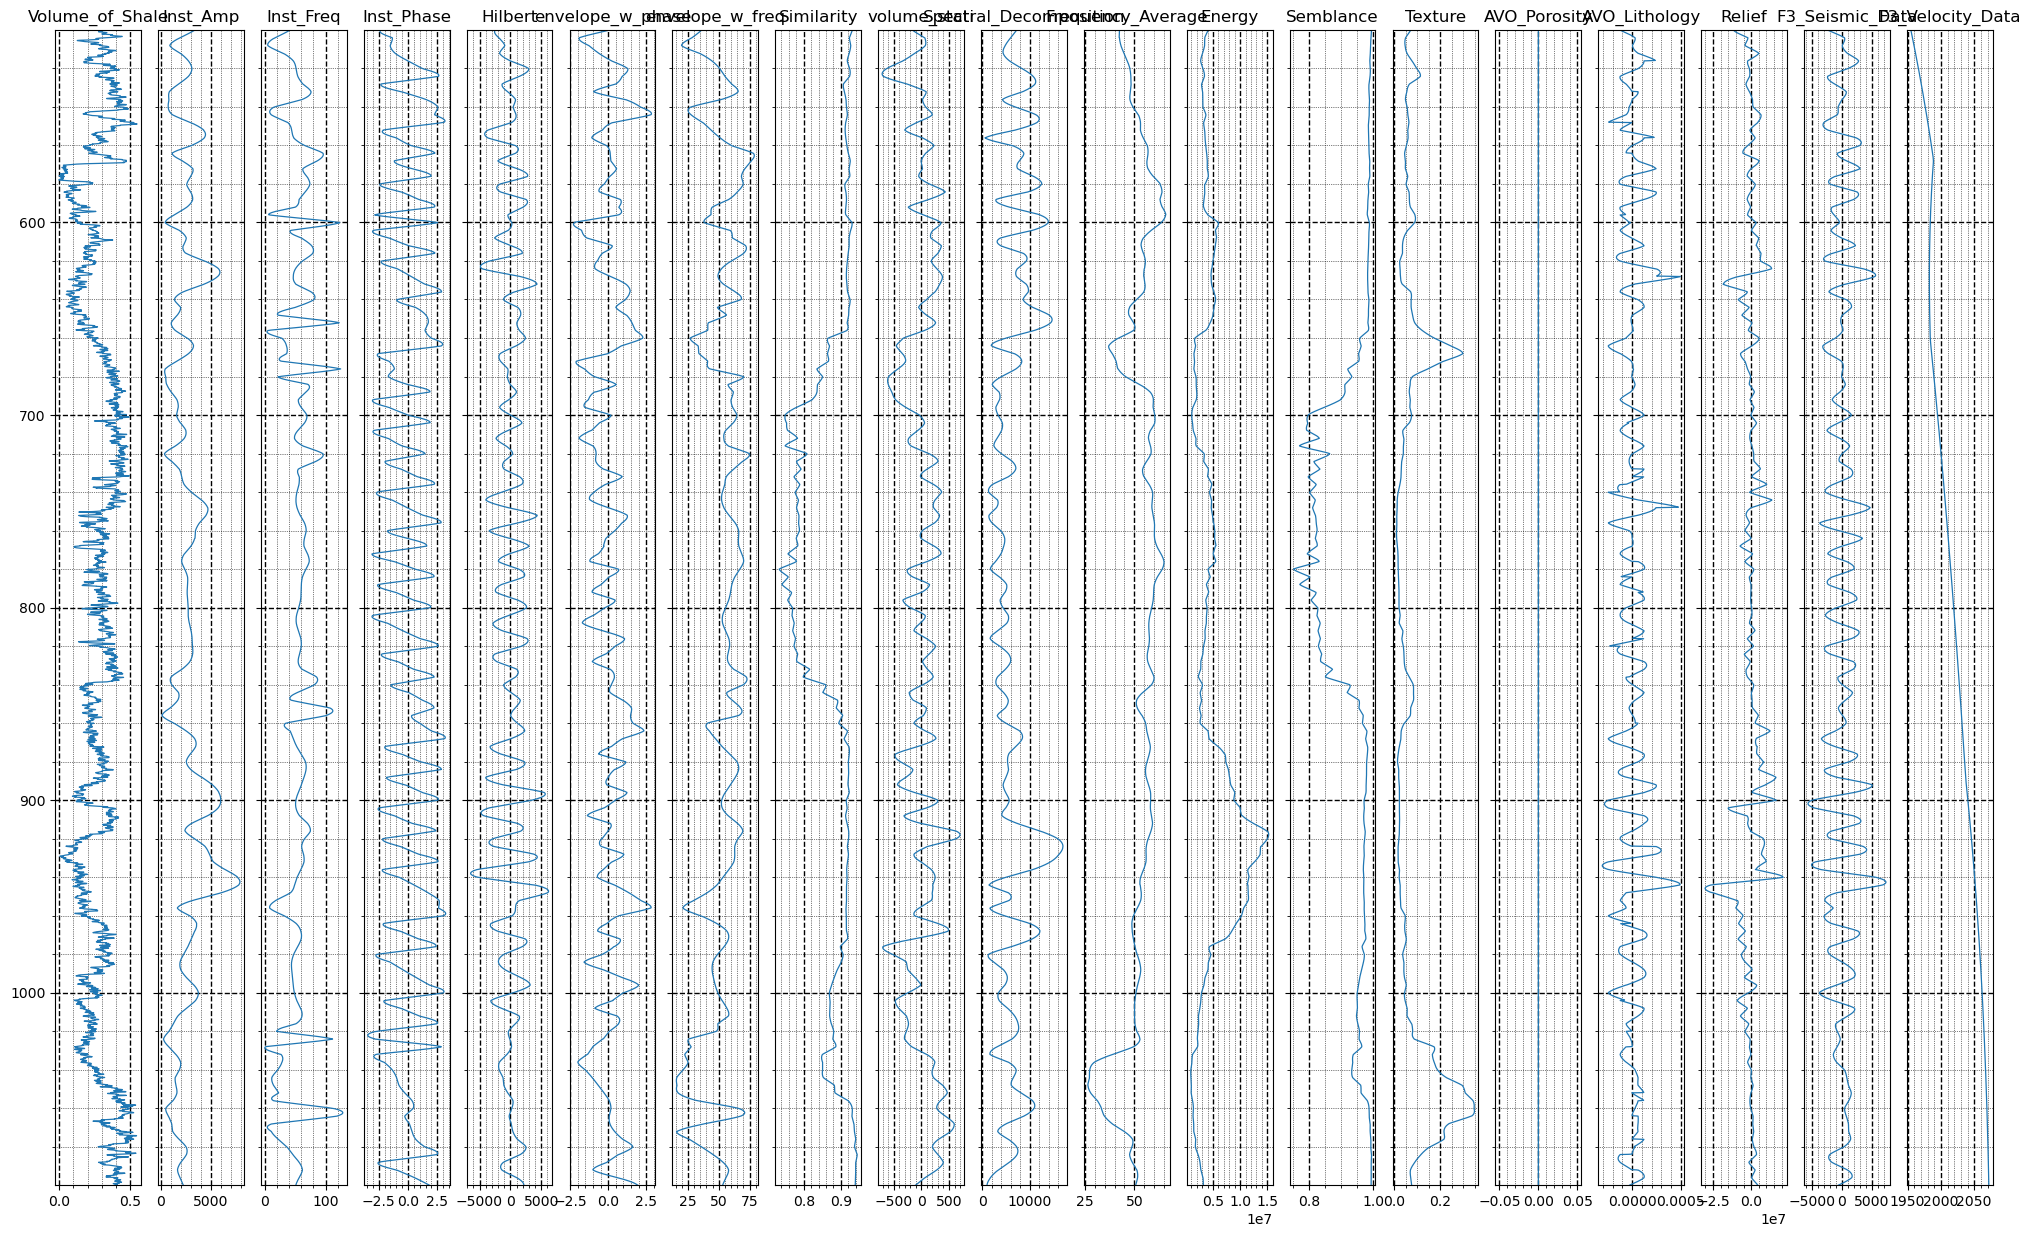

In [7]:
# Plot the inputs
rows, cols = 1,len(df_inter.columns)-1
fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(25,15), sharey=True)
names = [ 'Time', 'Volume_of_Shale', 'Inst_Amp', 'Inst_Freq', 'Inst_Phase', 'Hilbert',
       'envelope_w_phase', 'envelope_w_freq', 'Similarity', 'volume_stati', 'Spectral_Decomposition', 'Frequency_Average', 'Energy', 'Semblance', 'Texture','AVO_Porosity','AVO_Lithology','Relief','F3_Seismic_Data','F3_Velocity_Data']
for i in range(cols):
    ax[i].plot(df_inter.iloc[:,i+1], df_inter.iloc[:,0],linewidth='0.9')
    ax[i].set_ylim(max(df_inter.iloc[:, 0]), min(df_inter.iloc[:, 0]))
    ax[i].minorticks_on()
    ax[i].grid(which='major', linestyle='dashed', linewidth='1', color='black')
    ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax[i].set_title('%s' %names[i+1])

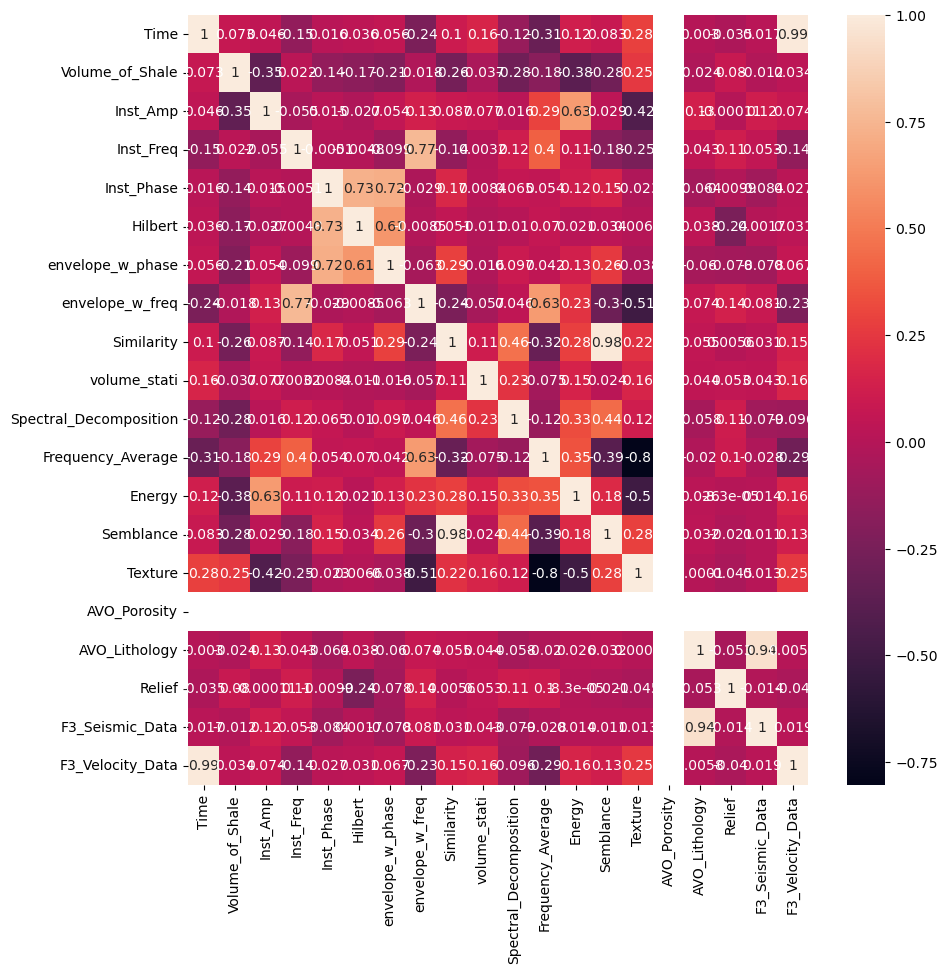

In [8]:
plt.figure(figsize = (10,10))
sns.heatmap(df_inter.corr(),annot = True)
plt.show()

In [9]:
# Define dataset and Prediction

Xdata = df_inter[[ 'Inst_Amp', 'Inst_Freq', 'Inst_Phase', 'Hilbert',
       'envelope_w_phase', 'envelope_w_freq', 'Similarity', 'volume_stati', 'Spectral_Decomposition', 'Frequency_Average', 'Energy', 'Semblance', 'Texture','AVO_Lithology','Relief','F3_Seismic_Data','F3_Velocity_Data']]
ydata = df_inter['Volume_of_Shale']

print("shape of Xdata: ",Xdata.shape)
print("shape of Ydata: ",ydata.shape)

shape of Xdata:  (7240, 17)
shape of Ydata:  (7240,)


In [10]:
scaler = StandardScaler()
# transform dataset 
data_scal = scaler.fit_transform(Xdata)
x_trans_data = pd.DataFrame(data_scal,columns = Xdata.columns)
x_trans_data

,Inst_Amp,Inst_Freq,Inst_Phase,Hilbert,envelope_w_phase,envelope_w_freq,Similarity,volume_stati,Spectral_Decomposition,Frequency_Average,Energy,Semblance,Texture,AVO_Lithology,Relief,F3_Seismic_Data,F3_Velocity_Data
0,0.549882,-0.590129,-1.492163,-1.228416,0.006352,-1.140701,0.931914,-0.645951,0.321794,-1.277674,-0.133277,0.861812,0.001940,-1.036580,-2.016985,-1.192631,-1.981383
1,0.525098,-0.615888,-1.507310,-1.239540,-0.053435,-1.154265,0.928379,-0.628565,0.311240,-1.277668,-0.139616,0.861467,-0.005282,-0.994685,-1.997672,-1.150923,-1.979313
2,0.512391,-0.629254,-1.513211,-1.244208,-0.083805,-1.161164,0.926564,-0.619428,0.305915,-1.277718,-0.142806,0.861273,-0.009034,-0.973642,-1.986230,-1.129778,-1.978277
3,0.486685,-0.656437,-1.523430,-1.252689,-0.144952,-1.175071,0.922897,-0.600744,0.295219,-1.277868,-0.149202,0.860864,-0.016668,-0.931498,-1.961680,-1.087240,-1.976218
4,0.460438,-0.684449,-1.530760,-1.259605,-0.206843,-1.189185,0.919153,-0.581311,0.284439,-1.278106,-0.155629,0.860420,-0.024541,-0.889230,-1.934087,-1.044247,-1.974152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7235,-0.261063,-0.130233,1.020981,1.084665,1.823101,0.081990,1.059263,-0.396625,-1.544075,-0.240770,-0.412955,0.846016,0.054655,-0.115455,0.731720,-0.201336,1.478550
7236,-0.258142,-0.132649,1.031879,1.085674,1.832844,0.079819,1.058508,-0.405578,-1.545379,-0.242735,-0.412662,0.845814,0.055666,-0.136199,0.740593,-0.219933,1.478644
7237,-0.255230,-0.135035,1.042776,1.086524,1.842363,0.077664,1.057744,-0.414547,-1.546648,-0.244699,-0.412364,0.845607,0.056679,-0.156113,0.749368,-0.238525,1.478738
7238,-0.252350,-0.137311,1.053676,1.086796,1.851065,0.075567,1.056923,-0.423566,-1.547792,-0.246659,-0.412049,0.845386,0.057707,-0.176028,0.757784,-0.257099,1.478824


In [11]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(x_trans_data, ydata, test_size=0.25)

RFR =RandomForestRegressor()
RFR.fit(X_train_0,y_train_0)
Ypred = RFR.predict(X_test_0)
RFR.score(X_test_0, y_test_0) * 100

99.05082024763414

# Feature Importance

In [12]:
feature_imp = pd.Series(RFR.feature_importances_,index=Xdata.columns).sort_values(ascending=False)
feature_imp

F3_Velocity_Data          0.312923
Similarity                0.189747
Energy                    0.088839
volume_stati              0.071744
Frequency_Average         0.063037
Relief                    0.031830
envelope_w_phase          0.030279
Texture                   0.028158
envelope_w_freq           0.027342
Semblance                 0.027279
AVO_Lithology             0.026386
Hilbert                   0.026266
Inst_Amp                  0.023083
Spectral_Decomposition    0.018459
Inst_Phase                0.014295
Inst_Freq                 0.010568
F3_Seismic_Data           0.009764
dtype: float64

In [13]:
data_featured = df_inter[['Time','Volume_of_Shale','F3_Velocity_Data', 'Similarity', 'Energy', 'volume_stati', 'Frequency_Average','Hilbert','Relief','Semblance']]
X_DATA = df_inter[['F3_Velocity_Data', 'Similarity', 'Energy', 'volume_stati', 'Frequency_Average','Hilbert','Relief','Semblance']]
Y_DATA = df_inter[['Volume_of_Shale']]
data_featured.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7240 entries, 7555 to 18214
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Time               7240 non-null   float64
 1   Volume_of_Shale    7240 non-null   float64
 2   F3_Velocity_Data   7240 non-null   float64
 3   Similarity         7240 non-null   float64
 4   Energy             7240 non-null   float64
 5   volume_stati       7240 non-null   float64
 6   Frequency_Average  7240 non-null   float64
 7   Hilbert            7240 non-null   float64
 8   Relief             7240 non-null   float64
 9   Semblance          7240 non-null   float64
dtypes: float64(10)
memory usage: 622.2 KB


In [14]:
data_scaled_2 = scaler.fit_transform(X_DATA)
X_DATA_S = pd.DataFrame(data_scaled_2, columns = X_DATA.columns)
X_train, X_test, y_train, y_test = train_test_split(X_DATA_S, Y_DATA, test_size=0.25)


# Model Selection: 

## 1. Linear Regression

In [15]:
linear_rg = LinearRegression()
linear_rg.fit(X_train, y_train)

pred_linear_rg_train = linear_rg.predict(X_train)
pred_linear_rg_test = linear_rg.predict(X_test)
pred_linear_rg = linear_rg.predict(X_DATA_S)

# Print the RMS Error and Score
print('RMSE for training data = ', round(mean_squared_error(y_train, pred_linear_rg_train), 4))
print('R2 Score for training data = ', round(r2_score(y_train, pred_linear_rg_train), 2))

print('RMSE for testing data = ', round(mean_squared_error(y_test, pred_linear_rg_test), 4))
print('R2 Score for testing data = ', round(r2_score(y_test, pred_linear_rg_test), 2))

RMSE for training data =  0.0077
R2 Score for training data =  0.36
RMSE for testing data =  0.0076
R2 Score for testing data =  0.37


## 2. Random Forest



In [16]:
RFR =RandomForestRegressor(random_state=42, max_depth=10)
RFR.fit(X_train,y_train)
# Estimate Predictions
pred_RFR_train= RFR.predict(X_train)
pred_RFR_test=RFR.predict(X_test)
pred_RFR = RFR.predict(X_DATA_S)
# Print the RMS Error and Score
print('RMSE for training data = ', round(mean_squared_error(y_train,pred_RFR_train), 4))
print('R2 Score for training data = ', round(r2_score(y_train, pred_RFR_train), 2))
print('RMSE for testing data = ', round(mean_squared_error(y_test,pred_RFR_test), 4))
print('R2 Score for testing data = ', round(r2_score(y_test, pred_RFR_test), 2))

E:\Programs\anaconda\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE for training data =  0.0006
R2 Score for training data =  0.95
RMSE for testing data =  0.0007
R2 Score for testing data =  0.94


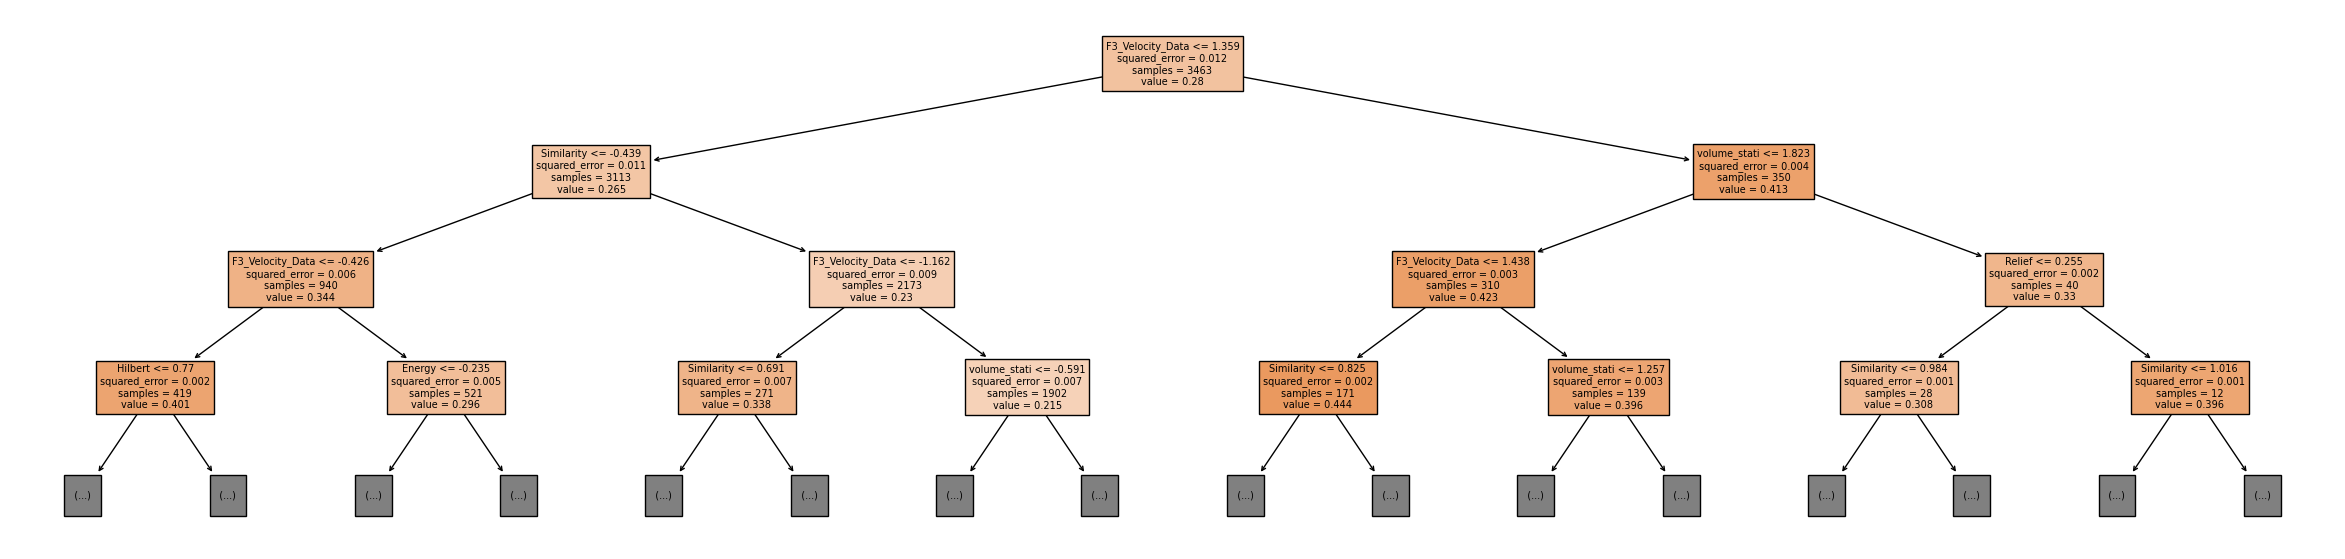

In [17]:
# Visualize the Forest
plt.figure(figsize=(30,7))
plot_tree(RFR.estimators_[20], max_depth=3, feature_names=X_train.columns, filled=True, rounded=False);

## 3. Nerual Network


E:\Programs\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Programs\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Programs\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Programs\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when 

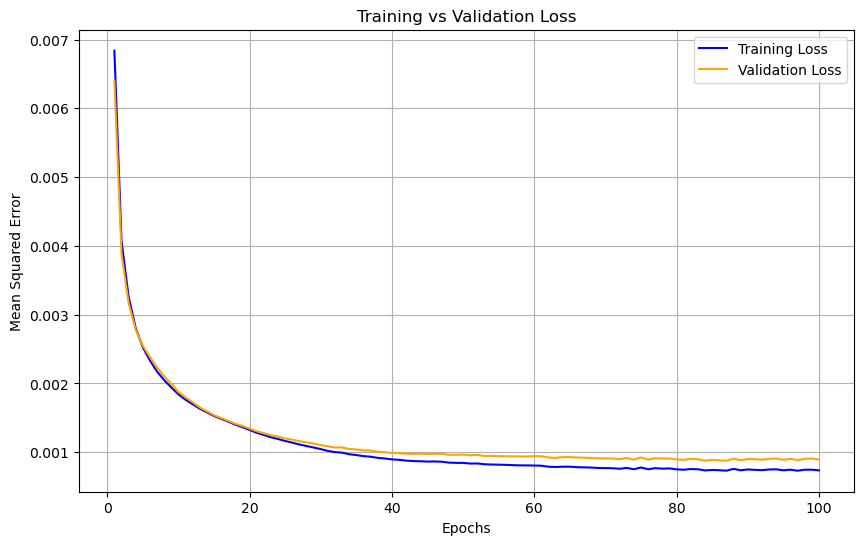

In [18]:
model_NN = MLPRegressor(hidden_layer_sizes=(50, 50, 50),      # Two hidden layers with 50 neurons each
                     activation='relu',                       # Activation function
                     solver='adam',                           # Optimizer
                     max_iter=100,                            # Number of epochs
                     random_state=42)

# Step 2: Train the model and track training and validation loss
train_loss = []
val_loss = []

for epoch in range(model_NN.max_iter):
    model_NN.partial_fit(X_train, y_train)  # Fit one epoch
    
    pred_xtrain = model_NN.predict(X_train)
    pred_xtest = model_NN.predict(X_test)

    MSE_T = mean_squared_error(y_train, pred_xtrain)  # Training loss
    MSE_V = mean_squared_error(y_test, pred_xtest)    # Validation loss
    
    train_loss.append(MSE_T)    
    val_loss.append(MSE_V)       
    
# Step 3: Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, model_NN.max_iter + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, model_NN.max_iter + 1), val_loss, label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid()
plt.show()

In [19]:
# Estimate Predictions
pred_model_NN_train= model_NN.predict(X_train)
pred_model_NN_test=model_NN.predict(X_test)
pred_model_NN = model_NN.predict(X_DATA_S)

# Print the RMS Error and Score
#TRAIN
print('RMSE for training data = ', round(mean_squared_error(y_train,pred_model_NN_train), 4))
print('R2 Score for training data = ', round(r2_score(y_train, pred_model_NN_train), 2))
#TEST
print('RMSE for testing data = ', round(mean_squared_error(y_test,pred_model_NN_test), 4))
print('R2 Score for testing data = ', round(r2_score(y_test, pred_model_NN_test), 2))

RMSE for training data =  0.0007
R2 Score for training data =  0.94
RMSE for testing data =  0.0009
R2 Score for testing data =  0.93


In [20]:
# Add the prediction columns to the DataFrame 'df'
data_featured['pred_L_reg'] = pred_linear_rg
data_featured['pred_RFR'] = pred_RFR
data_featured['pred_NN'] = pred_model_NN


# the prediction DataFrame
prediction_df = data_featured[['Time','Volume_of_Shale','pred_L_reg','pred_RFR','pred_NN']]
prediction_df

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_16396\3326278007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_featured['pred_L_reg'] = pred_linear_rg
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_16396\3326278007.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_featured['pred_RFR'] = pred_RFR
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_16396\3326278007.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,Time,Volume_of_Shale,pred_L_reg,pred_RFR,pred_NN
7555,500.098053,0.296800,0.354252,0.299786,0.291667
7557,500.214874,0.305192,0.353542,0.299900,0.291382
7558,500.273285,0.306987,0.353158,0.300011,0.291336
7560,500.390167,0.303800,0.352362,0.300011,0.291335
7562,500.507050,0.297977,0.351517,0.299912,0.291502
...,...,...,...,...,...
18209,1099.646606,0.410500,0.331990,0.406806,0.406654
18210,1099.702759,0.407776,0.332079,0.406804,0.407335
18211,1099.759033,0.403976,0.332170,0.406325,0.408006
18212,1099.815186,0.398280,0.332260,0.405292,0.409017


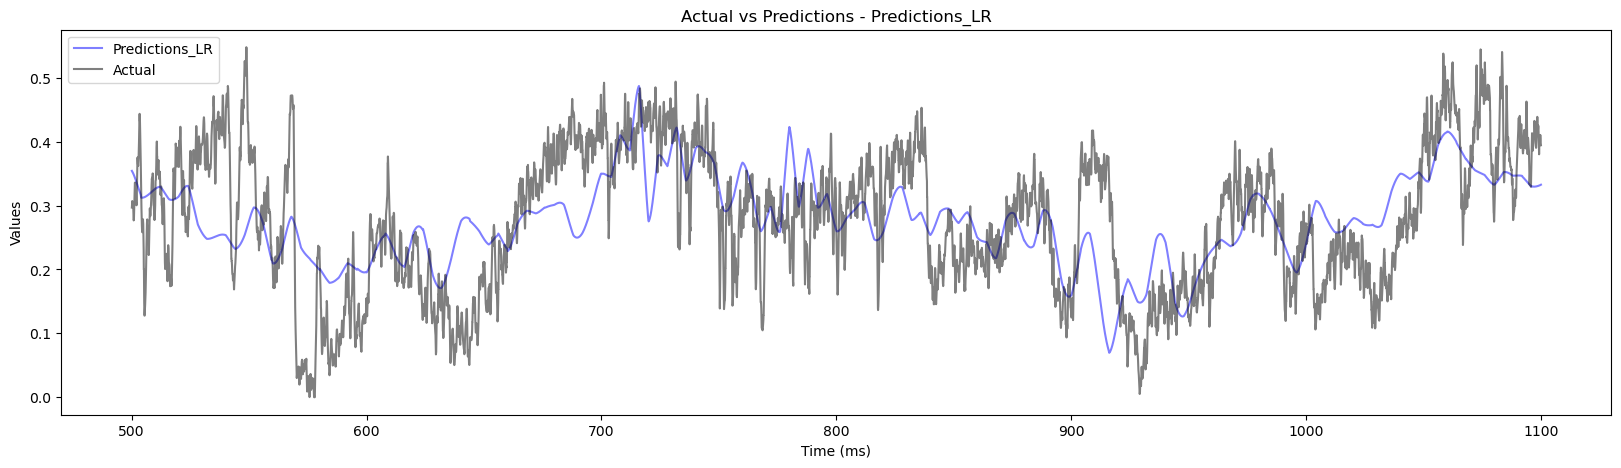

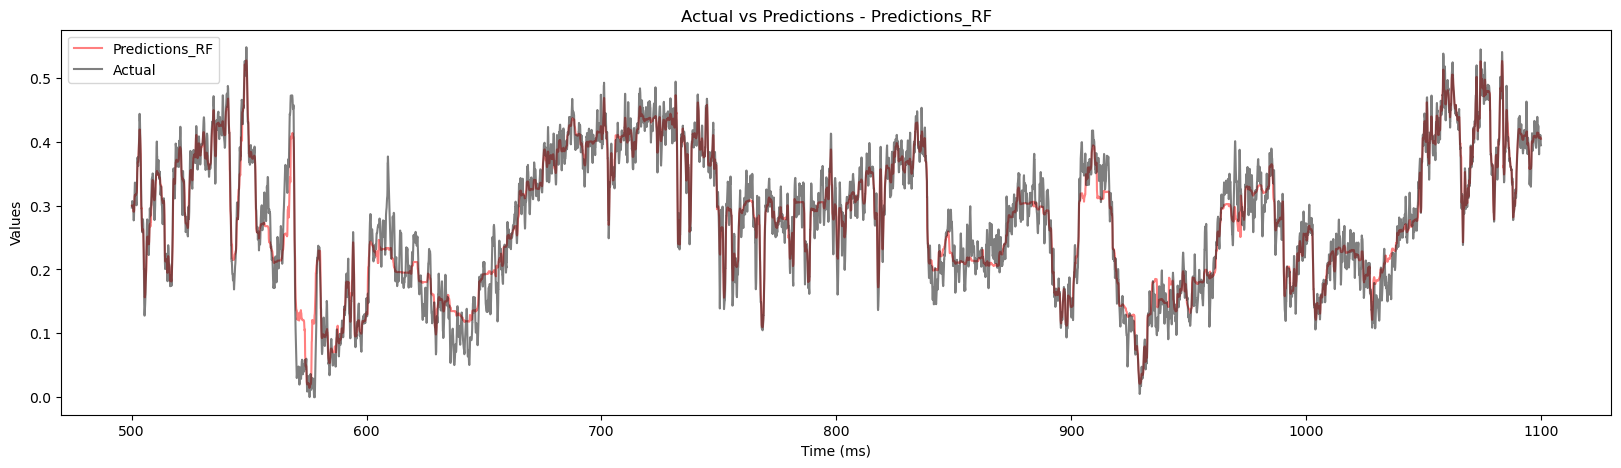

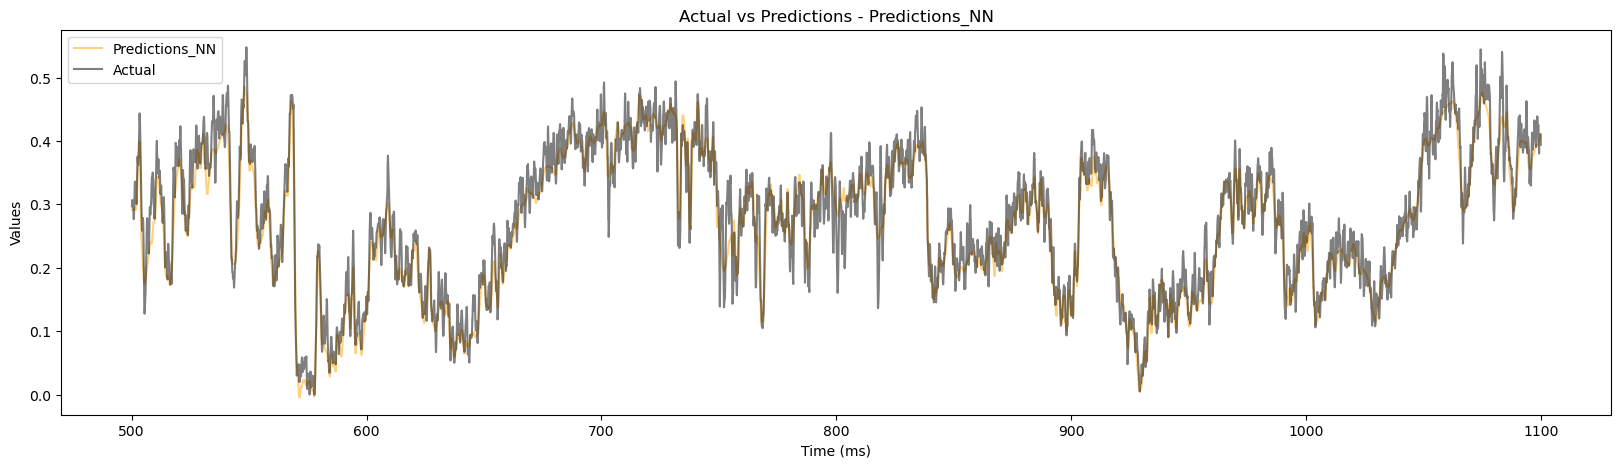

In [21]:
# Define a list of models and their respective colors and labels
models = [
    ('pred_L_reg', 'blue', 'Predictions_LR'),
    ('pred_RFR', 'red', 'Predictions_RF'),
    ('pred_NN', 'orange', 'Predictions_NN'),
]

# Actual values
actual = prediction_df['Volume_of_Shale']
depth = prediction_df['Time']

# Create separate plots for each model
for model, color, label in models:
    plt.figure(figsize=(20, 5))
    plt.plot(depth, prediction_df[model], c=color, alpha=0.5, label=label)
    plt.plot(depth, actual, c='black', alpha=0.5, label='Actual')

    # Labels and title
    plt.xlabel("Time (ms)")
    plt.ylabel("Values")
    plt.title(f"Actual vs Predictions - {label}")
    plt.legend()

    # Show the plot
    plt.show()

In [22]:
#@title Save the Trained Models
import joblib
# Save the models to a file
joblib.dump(linear_rg, r'E:\Datasets\reservior_simulation\Volume_of_Shale_models\linear_regression_model.pkl')
joblib.dump(RFR, r'E:\Datasets\reservior_simulation\Volume_of_Shale_models\random_forest_model.pkl')
joblib.dump(model_NN, r'E:\Datasets\reservior_simulation\Volume_of_Shale_models\neural_network_model.pkl')
print("Models saved successfully!")

Models saved successfully!
